In [5]:
""" import the Tilings package... """
import sys
sys.path.insert(0, '../Tilings') # prepend the path to the Tiling package
import Tilings as tl
""" import the other stuff """
import math, cmath
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx # graph tools
import QuantumGraph as QGraph
import AB_envs as envs
# interactivity in the notebook
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
# replace by %matplotlib notebook for full interactivity (but beware of the flickering!)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# Aim
This notebook aims at studying the electronic properties of the 8 folds environments found on the Ammann-Beenker tiling.
### The eighfold environments
What we call eightfold environements are the local environments around eighfold stars. The eighfold environements are all the same, and eighfold symmetric, up to 3rd neighbors (we will call this precise environment A8). After that, they start differing one from another.

Two A8 can overlap on the tiling, and in this case they will share exactly one outer lozenge. This situation happens when the centers of the two A8s are the two obtuse vertices of a lozenge prototile, inflated twice.
Since after two inflations, every vertex is an A8 center, we see that the relative frequency of overlaps per noninflated tile it the frequency of lozenges in the tiling.
Moreover, the lozenges and the squares occupy the same area in the tiling, and since the square area is $\sqrt{2}$ the lozenge area),
$$ f_\text{overlaps | prototile} = f_\text{lozenges | tiling} = 2-\sqrt{2} \simeq 0.58 $$

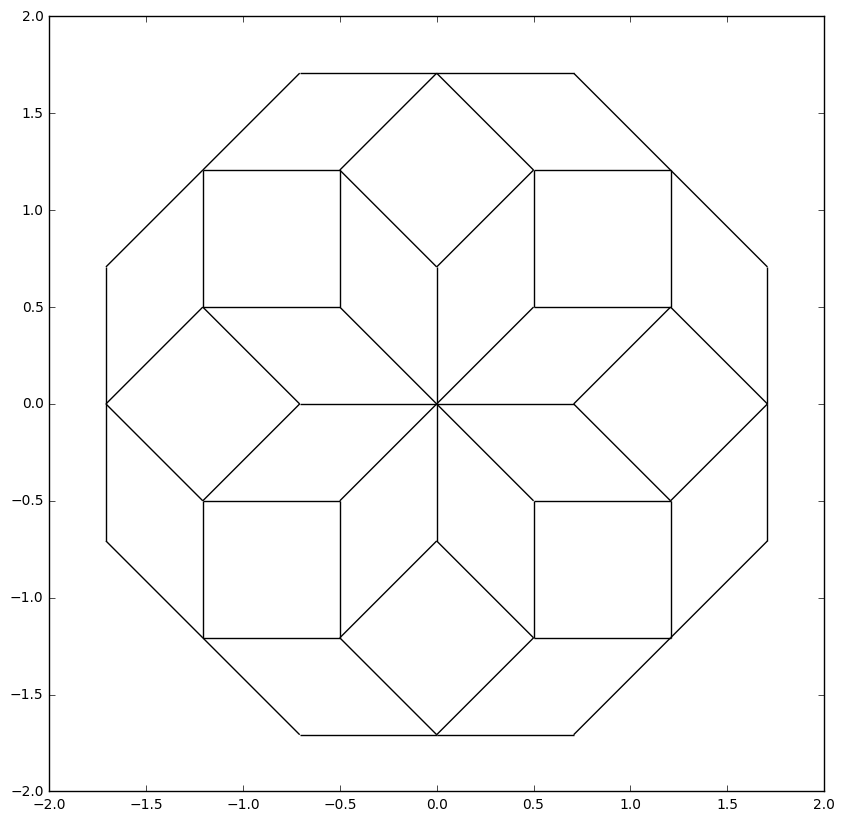

In [81]:
n = 0
A8 = tl.A5(envs.eightfold)
A8.it_sub(n)
lb = 1.+np.sqrt(2)
L = 2.
QGraph.plot(A8._graph, lims=((-L,L),(-L,L)), weights=1.)
plt.show()

In [82]:
ham = -1.*nx.to_numpy_matrix(A8._graph)
val, vec = np.linalg.eigh(ham)

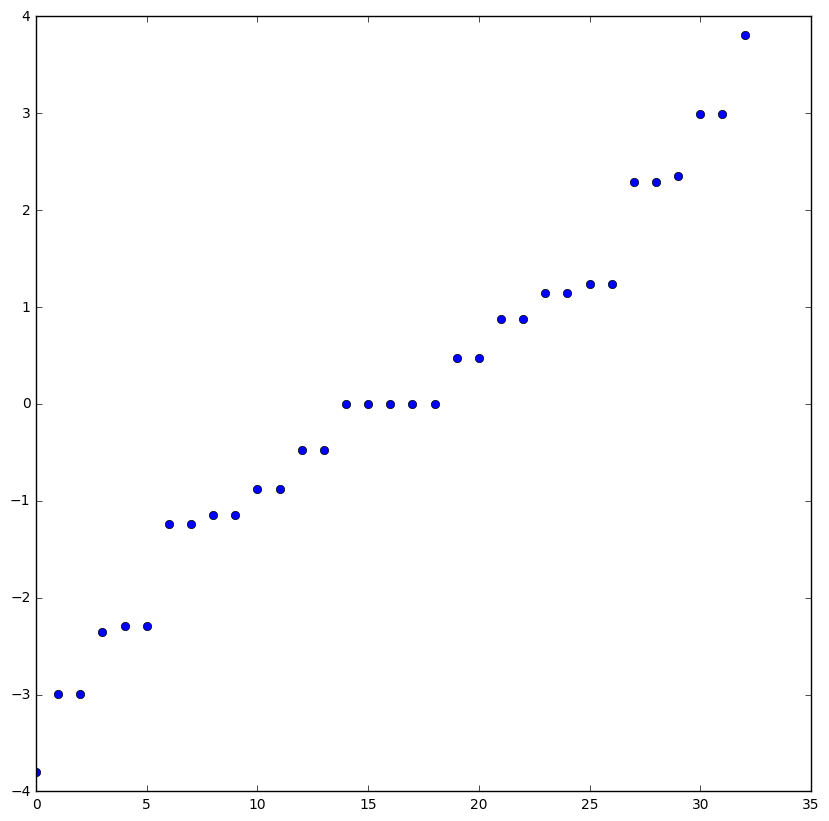

In [131]:
plt.plot(val, 'o')
plt.show()

In [132]:
plt.close()

def plot(state):
    wf = np.ndarray.flatten(np.asarray(vec[:,state]))
    prob = 10*10**3*np.abs(wf)**2
    phase = np.angle(wf)
    
    # relative size of the two subplots
    gs = gridspec.GridSpec(1, 2,
                       width_ratios=[2,1],
                       height_ratios=[1,1]
                       )
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    para_pos = nx.get_node_attributes(A8._graph, 'para')
    ax0.set_aspect('equal')
    L = 2.
    ax0.set_xlim((-L,L))
    ax0.set_ylim((-L,L))
    nx.draw_networkx(A8._graph, para_pos, with_labels = False, node_size = prob, node_color = phase, width = 1., ax = ax0)

    #ax[1].set_aspect()
    ax1.plot(val, range(len(A8._graph)), 'o', val[state], state, 'o')
    plt.show()

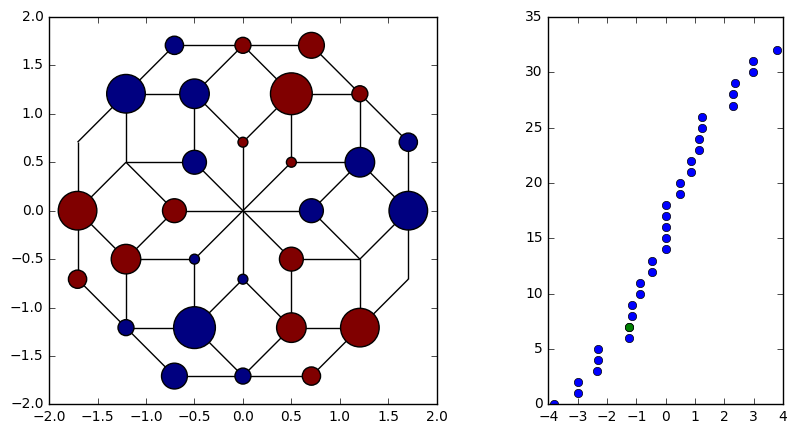

In [133]:
w = interactive(plot, state=(0,16,1))
display(w)

## Block-diagonalization using the symmetries

The A8 environement (and therefore its Hamiltonian) has the symmetry group of an octagon: the diedral group $D_{16}$.
It has two generators: 
* $R$, the counterclockwise rotation of $1/8$ turn
* $P$, the reflection about the horizontal axis

We know that the Hamiltonian is going to commute with the corresponding operators (which we will call $\hat R$ and $\hat P$).
We need to write them in the atomic basis (in 4D space).
Let $e_i$ be the canonical basis of $\mathbb{Z}^4$.
Because each atom can be represented as a vector of $\mathbb{Z}^4$, all we need is to write the action $R$ (the action $P$) of the rotation $\hat R$ (of the reflection $\hat P$) on the basis of $\mathbb{Z}^4$.
We obtain
$$ R = 
\begin{bmatrix}
	0 & 0 & 0 & -1\\
	1 & 0 & 0 & 0\\
	0 & 1 & 0 & 0\\
	0 & 0 & 1 & 0\\
\end{bmatrix} $$
and
$$ P = 
\begin{bmatrix}
	1 & 0 & 0 & 0\\
	0 & 0 & 0 & -1\\
	0 & 0 & -1 & 0\\
	0 & -1 & 0 & 0\\
\end{bmatrix} $$
Moreover, if $| p \rangle$ and $| q \rangle$ are the localized wavefunctions on two atoms represented by the 4D vectors $p$ and $q$, we have trivially
$$ \langle p | \hat R | q \rangle = \delta_{p, R q} $$

In [138]:
e = np.identity(4)

R = np.array([[0,0,0,-1],[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P = np.array([[1,0,0,0],[0,0,0,-1],[0,0,-1,0],[0,-1,0,0]])

proj = A8.para()

def k(p1, p2):
    return (np.asarray(p1, dtype=int) == np.asarray(p2, dtype=int)).all()

Rop = np.matrix([[k(p2, np.dot(R, p1)) for p1 in A8._graph] for p2 in A8._graph], dtype=int)
Pop = np.matrix([[k(p2, np.dot(P, p1)) for p1 in A8._graph] for p2 in A8._graph], dtype=int)
# Hamiltonian operator
H = -1.*nx.to_numpy_matrix(A8._graph)

In [139]:
# check that H commutes with the symmetry operators
print((H.dot(Rop) - Rop.dot(H) == 0).all())
print((H.dot(Pop) - Pop.dot(H) == 0).all())

True
True


In [175]:
# diagonalize the rotation operator (UR is a unitary matrix)
valsR, UR = np.linalg.eig(Rop)
# diagonalize the reflection operator (PP is not a unitary matrix)
valsP, PP = np.linalg.eig(Pop)
PPinv = np.linalg.inv(PP)

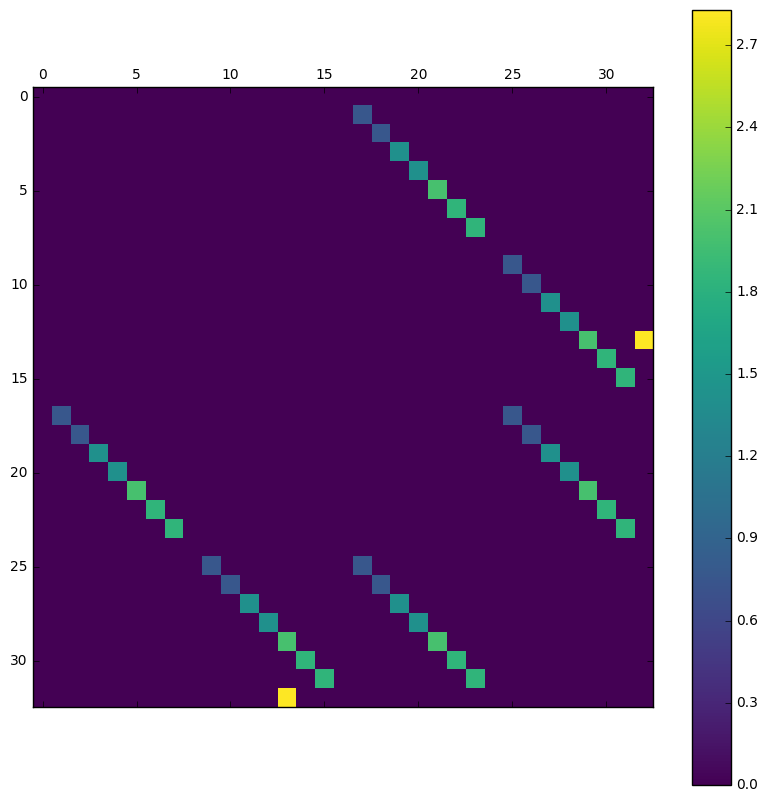

In [180]:
Hr = (UR.H).dot(H).dot(UR)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(np.abs(Hr), cmap="viridis")
fig.colorbar(cax)

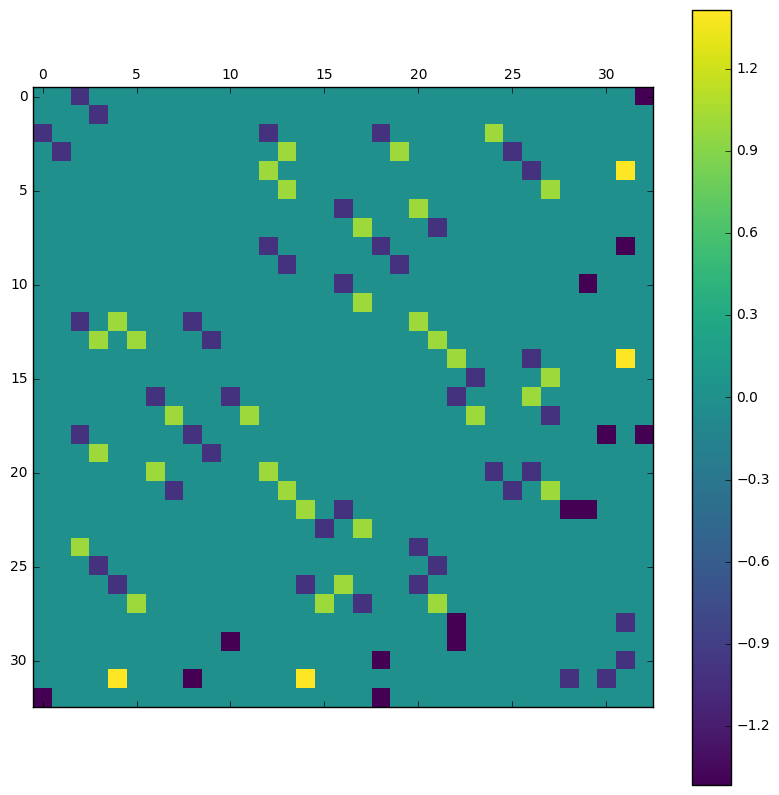

In [179]:
Hp = PPinv.dot(H).dot(PP)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(Hp.real, cmap="viridis")
fig.colorbar(cax)

In [183]:
Hshifted = H + 10*Rop

valshifted, vecshifted = np.linalg.eig(Hshifted)

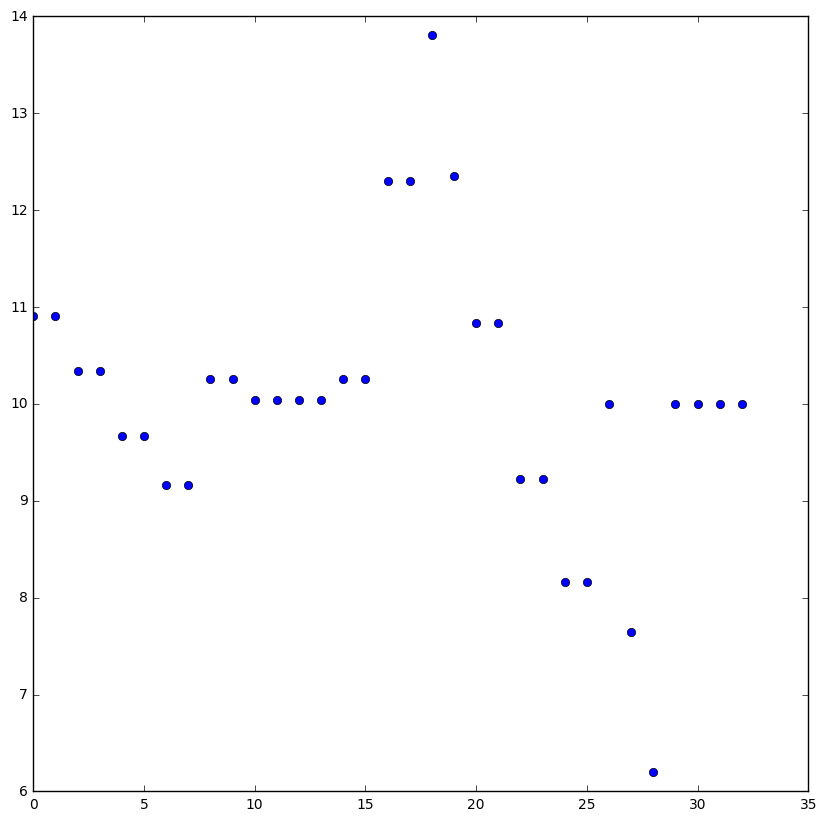

In [186]:
plt.plot(np.abs(valshifted), 'o')
plt.show()